In [ ]:
# pip install --upgrade google-cloud-bigquery
# pip install --upgrade pyarrow 
# !pip install marketing_attribution_models
# !pip install chart_studio

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
import plotly.graph_objects as go
from chart_studio.plotly import iplot
import seaborn as sns
import matplotlib.pyplot as plt
from  marketing_attribution_models  import  MAM

# 1. SQL and Data Cleaning
## 1.1 Connect to BigQuery and test connection

In [ ]:
project_id = "marketing-analysis"
client = bigquery.Client(project=project_id)

In [ ]:
# Testing
query_job = client.query("""
SELECT * 
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20160801`
LIMIT 50""")
results = query_job.to_dataframe()
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   visitorId             0 non-null      object
 1   visitNumber           50 non-null     int64 
 2   visitId               50 non-null     int64 
 3   visitStartTime        50 non-null     int64 
 4   date                  50 non-null     object
 5   totals                50 non-null     object
 6   trafficSource         50 non-null     object
 7   device                50 non-null     object
 8   geoNetwork            50 non-null     object
 9   customDimensions      50 non-null     object
 10  hits                  50 non-null     object
 11  fullVisitorId         50 non-null     object
 12  userId                0 non-null      object
 13  channelGrouping       50 non-null     object
 14  socialEngagementType  50 non-null     object
dtypes: int64(3), object(12)
memory usage: 6.0+

In [ ]:
# See what data is in traffic source 
# Check the first few records to find key data
query_ts = client.query("""
SELECT fullVisitorId, date, channelGrouping, trafficSource.source AS traffic_source
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20160801`
LIMIT 50""")

query_ts = query_ts.to_dataframe()
query_ts['traffic_source'].unique()

array(['youtube.com', 'l.facebook.com', 'm.facebook.com', 'facebook.com',
       '(direct)', 'google'], dtype=object)

In [ ]:
query_ts.head()

,fullVisitorId,date,channelGrouping,traffic_source
0,7194065619159478122,20160801,Social,youtube.com
1,8159312408158297118,20160801,Social,youtube.com
2,9236304747882138291,20160801,Social,youtube.com
3,1792676004815023069,20160801,Social,youtube.com
4,7305625498291809599,20160801,Social,youtube.com


## 1.2 Querying data using SQL

In [ ]:
# Get all the data
query_job = client.query("""
SELECT fullVisitorId, date, channelGrouping,
    trafficSource.source AS traffic_source,
    SUM ( totals.transactions ) AS total_transactions, 
    SUM ( totals.totalTransactionRevenue ) AS total_transaction_revenue
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY fullVisitorId, date, channelGrouping, traffic_source;""")
df = query_job.to_dataframe().sort_values(by='total_transactions',ascending=False)
df.head()

,fullVisitorId,date,channelGrouping,traffic_source,total_transactions,total_transaction_revenue
215095,5526675926038480325,20170304,Direct,(direct),25.0,1.938090e+09
449854,4983264713224875783,20170304,Direct,(direct),21.0,1.576330e+09
231902,8637158932301658318,20170531,Referral,(direct),15.0,3.820000e+08
51684,9662800125044386280,20161021,Organic Search,(direct),14.0,3.163040e+09
315588,7713012430069756739,20170302,Organic Search,google,12.0,1.319630e+09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847224 entries, 215095 to 847223
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   fullVisitorId              847224 non-null  object 
 1   date                       847224 non-null  object 
 2   channelGrouping            847224 non-null  object 
 3   traffic_source             847224 non-null  object 
 4   total_transactions         11458 non-null   float64
 5   total_transaction_revenue  11423 non-null   float64
dtypes: float64(2), object(4)
memory usage: 45.2+ MB


In [ ]:
# Save file
#df.to_csv('bigquery_ga.csv')

## 1.2 Data Cleaning

In [ ]:
# Read file if saved
#df = pd.read_csv('bigquery_ga.csv',index_col=0)
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')

In [ ]:
# Check unique value counts of 'channelGrouping' and 'traffic_source' columns
df['channelGrouping'].value_counts()

Organic Search    356052
Social            222610
Direct            131037
Referral           94410
Paid Search        22506
Affiliates         15062
Display             5440
(Other)              107
Name: channelGrouping, dtype: int64

In [ ]:
df['traffic_source'].value_counts()

(direct)                    341327
google                      224182
youtube.com                 209881
Partners                     15069
analytics.google.com         14328
                             ...  
ixquick.com                      1
digg.com                         1
se.yhs4.search.yahoo.com         1
msn                              1
earth.google.com                 1
Name: traffic_source, Length: 275, dtype: int64

In [ ]:
# Clean the data and group some of the traffic sources together
df_clean = df
df_clean['traffic_source_clean']=df_clean['traffic_source'].str.lower().replace('\\.com', '').replace('^m\\.', '')
# Any tracfic source with address such as 'sites.google.com' will be transformed to 'google_product'
df_clean.loc[df_clean['traffic_source_clean'].str.contains('\\.google', case=False), 'traffic_source_clean'] = 'google_product'
# Any tracfic source with address starts with 'google.' will be transformed to 'google'
df_clean.loc[df_clean['traffic_source_clean'].str.contains('google\\.', case=False), 'traffic_source_clean'] = 'google'
# Any tracfic source with address that contains 'facebook' will be transformed to 'facebook'
df_clean.loc[df_clean['traffic_source_clean'].str.contains('facebook', case=False), 'traffic_source_clean'] = 'facebook'
# Any tracfic source with address that contains 'youtube' will be transformed to 'youtube'
df_clean.loc[df_clean['traffic_source_clean'].str.contains('youtube', case=False), 'traffic_source_clean'] = 'youtube'
# Any tracfic source with address that contains 'yahoo' will be transformed to 'facebook'
df_clean.loc[df_clean['traffic_source_clean'].str.contains('yahoo', case=False), 'traffic_source_clean'] = 'yahoo'

In [ ]:
# Check 'traffic_source_clean' value after cleaning
df_clean['traffic_source_clean'].value_counts().head(10)

(direct)                   341327
google                     229546
youtube                    209971
google_product              21146
partners                    15069
facebook                     6121
dfa                          4935
baidu                        3287
siliconvalley.about.com      1992
reddit.com                   1882
Name: traffic_source_clean, dtype: int64

- Notice that there's a big gap in value between No.3 and No.4 traffic source
- To narrow down our analysis, we only focus on the Top 3 traffic sources 

In [ ]:
# Group the rest of the traffic address into "other source"
not_top3 = df_clean.groupby('traffic_source_clean').size().sort_values(ascending=False).index[3:]
df_clean['traffic_source_clean'] = df_clean['traffic_source_clean'].replace(not_top3, 'Other')
df_clean['traffic_source_clean'].value_counts()

(direct)    341327
google      229546
youtube     209971
Other        66380
Name: traffic_source_clean, dtype: int64

# 2. EDA
## 2.1 Understand Channel-Source Combination
- "Last Click" Attribution Analysis

In [ ]:
# Group the data by channel and traffic source
# Sum up the 'total_transactions' and 'total_transaction_revenue' in each group
# Calculate 'revenue_per_conversion' by dividing 'total_transaction_revenue' and the size of each group
df_channelvalue = df_clean.groupby(['channelGrouping','traffic_source_clean']).size().to_frame(name = 'count').reset_index()
df_channelvalue['total_transactions'] =df_clean.groupby(['channelGrouping','traffic_source_clean'])['total_transactions'].sum().to_frame(name='total_transactions').reset_index()['total_transactions']
df_channelvalue['total_transaction_revenue'] =df_clean.groupby(['channelGrouping','traffic_source_clean'])['total_transaction_revenue'].sum().to_frame(name='total_transaction_revenue').reset_index()['total_transaction_revenue']
df_channelvalue['revenue_per_conversion'] = (df_channelvalue['total_transaction_revenue']/df_channelvalue['count']).round(decimals=2)
df_channelvalue

,channelGrouping,traffic_source_clean,count,total_transactions,total_transaction_revenue,revenue_per_conversion
0,(Other),(direct),2,0.0,0.000000e+00,0.00
1,(Other),Other,72,0.0,0.000000e+00,0.00
2,(Other),google,33,1.0,1.199000e+07,363333.33
3,Affiliates,Other,15062,9.0,6.543800e+08,43445.76
4,Direct,(direct),131037,2219.0,4.985300e+11,3804498.20
5,Display,(direct),73,2.0,7.727000e+07,1058493.15
6,Display,Other,4935,132.0,1.287872e+11,26096686.93
7,Display,google,432,18.0,1.472140e+09,3407731.48
8,Organic Search,(direct),137501,1360.0,1.354698e+11,985227.45
9,Organic Search,Other,6426,47.0,2.631080e+09,409442.89


In [ ]:
# df_channelvalue['total_transactions'] = df_channelvalue['total_transactions'].astype('int64')
# df_channelvalue['total_transaction_revenue'] = df_channelvalue['total_transaction_revenue'].astype('int64')

## 2.2 Visualize the findings 

In [ ]:
# Visualize Average Revenue Per Channel
data = px.data.gapminder()
df_channelvalue= df_channelvalue.sort_values(by='revenue_per_conversion',ascending=True)
fig = px.bar(df_channelvalue, x=df_channelvalue['revenue_per_conversion'], y= df_channelvalue['channelGrouping'].astype(str)+' '+df_channelvalue['traffic_source_clean'],
             hover_data = ['total_transaction_revenue', 'total_transactions'], color='revenue_per_conversion',
             labels={'total_transaction_revenue':'Total Revenue','revenue_per_conversion':'Revenue per Entry',
                     'total_transactions':'Total Transations'}, height=500,orientation='h')
fig.update_layout(title_text='Average Revenue Per Channel Channel')
fig.show()

In [ ]:
# Visualize Total Revenue
data = px.data.gapminder()
df_channelvalue = df_channelvalue.sort_values(by='total_transaction_revenue',ascending=True)
fig = px.bar(df_channelvalue, x=df_channelvalue['total_transaction_revenue'], y= df_channelvalue['channelGrouping'].astype(str)+' '+df_channelvalue['traffic_source_clean'],
             hover_data = ['total_transaction_revenue', 'total_transactions'], color='total_transaction_revenue',
             labels={'total_transaction_revenue':'Total Revenue','revenue_per_conversion':'Revenue per Entry',
                     'total_transactions':'Total Transations'}, height=500,orientation='h')
fig.update_layout(title_text='Total Revenue Per Channel Channel')
fig.show()

# 3. Channel-Path Analysis

In [ ]:
# Add Channel-Traffic Source Combination
df_clean['channel_source'] = df_clean['channelGrouping'].astype(str)+'-'+df_clean['traffic_source_clean']
df_clean = df_clean.drop(columns=['channelGrouping','traffic_source'])

# Binarize 'conversion' base on number of total transactions
df_clean['conversion'] =df_clean['total_transactions'].apply(lambda x: 1 if  x > 0 else 0)

In [ ]:
# Create Channel-Path dataframe
# Group the table by visitor ID and compress all the channel source into one column, values separated by '>'
# Sum up numbers of channel source, conversion and conversion value
gb = df_clean.groupby(['fullVisitorId'])
df_channelpath = gb.agg({'channel_source':' > '.join})
df_channelpath = df_channelpath.join(gb.agg({'channel_source':'size',
                             'conversion': 'sum',
                             'total_transaction_revenue': 'sum'}).rename(
                                 columns={'channel_source':'n_channel_path',
                                          'conversion': 'conversion_total',
                                          'total_transaction_revenue': 'conversion_value'})).reset_index()

- ### Longest Channel Path?

In [ ]:
df_channelpath.sort_values(by='n_channel_path',ascending=False)

,fullVisitorId,channel_source,n_channel_path,conversion_total,conversion_value
139589,1957458976293878100,Display-Other > Display-Other > Display-Other ...,146,14,1.284125e+11
257343,3608475193341679870,Paid Search-google > Direct-(direct) > Direct-...,131,1,2.748000e+07
51304,0720311197761340948,Social-Other > Social-Other > Social-Other > S...,119,0,0.000000e+00
58716,0824839726118485274,Organic Search-google > Organic Search-(direct...,117,0,0.000000e+00
287807,4038076683036146727,Paid Search-(direct) > Paid Search-(direct) > ...,110,0,0.000000e+00
...,...,...,...,...,...
250855,3518575285827520729,Organic Search-google,1,0,0.000000e+00
250856,3518578981406393564,Affiliates-Other,1,0,0.000000e+00
250857,3518582764251994866,Social-youtube,1,0,0.000000e+00
250858,3518590454951981256,Direct-(direct),1,0,0.000000e+00


- ### Most Path Conversions?

In [ ]:
df_channelpath.sort_values(by='conversion_total',ascending=False)

,fullVisitorId,channel_source,n_channel_path,conversion_total,conversion_value
557953,7813149961404844386,Direct-(direct) > Direct-(direct) > Direct-(di...,50,28,2.786510e+09
355406,4984366501121503466,Direct-(direct) > Direct-(direct) > Direct-(di...,21,16,9.649400e+09
171253,2402527199731150932,Direct-(direct) > Direct-(direct) > Direct-(di...,28,15,3.736810e+09
139589,1957458976293878100,Display-Other > Display-Other > Display-Other ...,146,14,1.284125e+11
482512,6760732402251466726,Referral-(direct) > Referral-(direct) > Referr...,29,14,6.495480e+09
...,...,...,...,...,...
239706,336286767069572297,Social-youtube > Organic Search-(direct),2,0,0.000000e+00
239707,3362869754320830266,Social-youtube,1,0,0.000000e+00
239708,3362887286509658825,Social-youtube,1,0,0.000000e+00
239709,3362887836351430530,Social-youtube,1,0,0.000000e+00


## 4.0 Channel Attribution Modeling 

In [ ]:
attributions  =  MAM ( df_channelpath ,
      group_channels = False ,
      channels_colname  =  'channel_source' ,
      path_separator = ' > ',
      conversion_value = 'conversion_value' )

In [ ]:
# Generate Heurisitic Models
first_click = attributions.attribution_first_click()
last_click = attributions.attribution_last_click()
linear = attributions.attribution_linear()

# Generate Markov Chain Models
markov = attributions.attribution_markov(transition_to_same_state = False)

# Extract model value to dataframe
df_models = attributions.group_by_channels_models

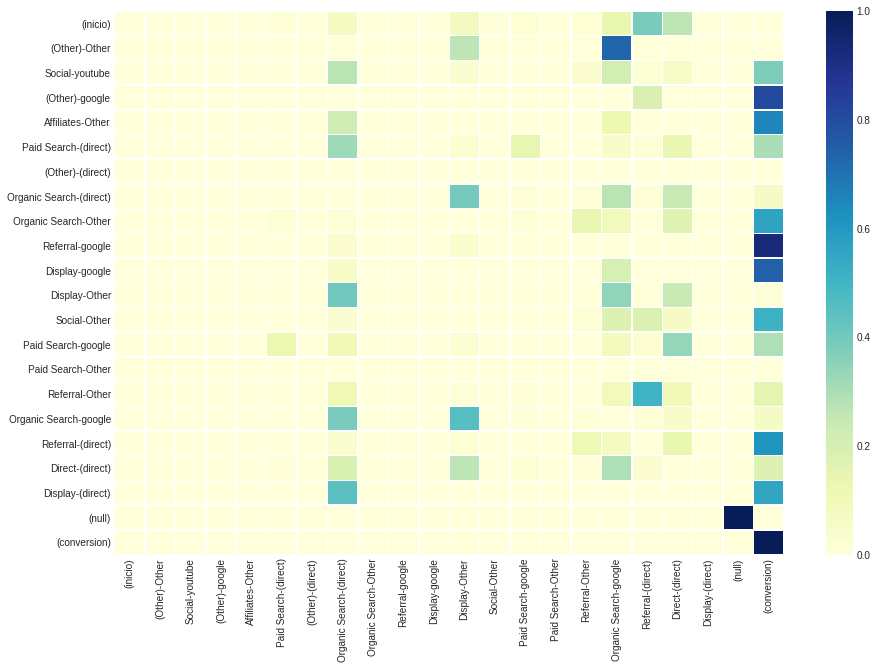

In [ ]:
# Markov Chain transition matrix heatmap
ax,fig = plt.subplots(figsize = ( 15 , 10 ))
sns.heatmap(markov[2].round(3),cmap="YlGnBu", annot=False, linewidths = .5 )

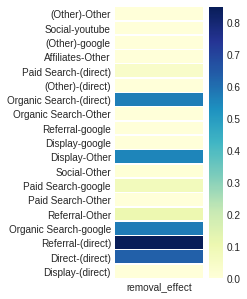

In [ ]:
# Markov Chain Model Removal Effect Plot
ax,fig  =  plt.subplots(figsize = ( 2 , 5 ))
sns.heatmap(markov[ 3 ].round(3), cmap = "YlGnBu" , annot = False , linewidths = .5 )

In [ ]:
# Getting model ready for plot
df_models.columns = ['channels','first_click','last_click','linear','markov_chain']
df_plot = df_models.melt(id_vars= 'channels',value_name='value',value_vars=['first_click','last_click', 'linear','markov_chain']).sort_values('value',ascending=False)

In [ ]:
# Create a function to generate grouped bar chart
def group_bar_plot(dataframe, x, y, group, **kwargs):
    items = dataframe[group].unique()
    data = []
    for item in items:
        group_item = dataframe[dataframe[group]==item]
        data.append(
            go.Bar(
                x = group_item[x],
                y = group_item[y],
                name = str(item)
            ) 
        )
    layout = go.Layout(barmode='group',yaxis_title="Conversion Value")
    layout.update(kwargs)
    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [ ]:
# Plot models outcomes
group_bar_plot(df_plot,'channels','value','variable')


# 5. Customer Journey Analysis
## 5.1 Initial findings

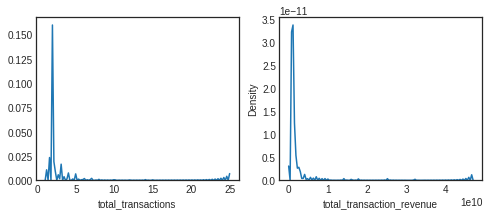

In [ ]:
lst = ['total_transactions','total_transaction_revenue']
idx= 0
fig, ax =plt.subplots(1,2)
for col in lst: 
  sns.distplot(df[col], hist=False, kde=True,ax=ax[idx])
  idx=idx+1
  fig.set_size_inches(8, 3)
  plt.ylabel('Density')
  fig.show()

In [ ]:
def view_user_detail(data,id):
  if id in data.fullVisitorId.values:
    # pd.set_option('display.max_rows', None)
    return data[data['fullVisitorId']==id].sort_values(by='date',ascending=True)
  else:
    return -1

In [ ]:
df_view = view_user_detail(df,'2402527199731150932')
df_view.to_csv('df_view.csv')

In [ ]:
# Create a table for futher analysis
df_clv = df[['fullVisitorId', 'date', 'channelGrouping','total_transactions']]
df_clv = df_clv.groupby(['fullVisitorId','date','channelGrouping'])['total_transactions'].sum().astype('int64').reset_index()

# Flag the conversion
df_clv['flag'] = df_clv['total_transactions'].apply(lambda x: 1 if  x > 0 else 0)
# Cummulate the conversion number as path of customer journey
df_clv['paths'] = df_clv.groupby(['fullVisitorId'])['flag'].apply(lambda x: x.cumsum()).to_frame(name='paths').reset_index()['paths']
df_clv['path_id'] = df_clv['paths'].shift(1)
df_clv['path_id'] = df_clv['path_id'].fillna(0).astype('int64')
df_clv['path_id'] = df_clv['path_id']+1
df_clv['visitor_path_id'] = df_clv['fullVisitorId'].astype(str)+'_'+df_clv['path_id'].astype(str)
# Assign the last occurance of flag value to indicate there's a transaction happened in that path
df_clv['transaction_flag'] = df_clv.visitor_path_id.map(df_clv.groupby('visitor_path_id').flag.nth(-1))


In [ ]:
# Create a table for visualizing the customer journey
df_cj = df_clv[['visitor_path_id','transaction_flag', 'path_id', 'channelGrouping']]
df_cj = df_cj[df_cj['transaction_flag']==1]
df_cj = df_cj.groupby(['channelGrouping', 'path_id']).size().to_frame(name='count').reset_index()
df_cj['prob'] = df_cj.groupby('path_id')['count'].apply(lambda x: x/x.sum())
df_cj = df_cj[df_cj['path_id']<=12]
df_cj = df_cj.drop(columns=['count'],axis=1)

- ### Animation Plot for Customer Journey

In [ ]:

fig=px.scatter(df_cj, x="prob", y="channelGrouping", animation_frame="path_id",
            hover_name="prob",range_x=[0,0.7])
fig.layout.xaxis.tickformat = ',.0%'
fig.update_traces(marker=dict(size=12))
fig.show()

In [ ]:
pivotted= df_cj.pivot('path_id','channelGrouping','prob')
pivotted = pivotted.fillna(0)

- ### Heatmap of Customer Journey

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text major ticklabel objects>)

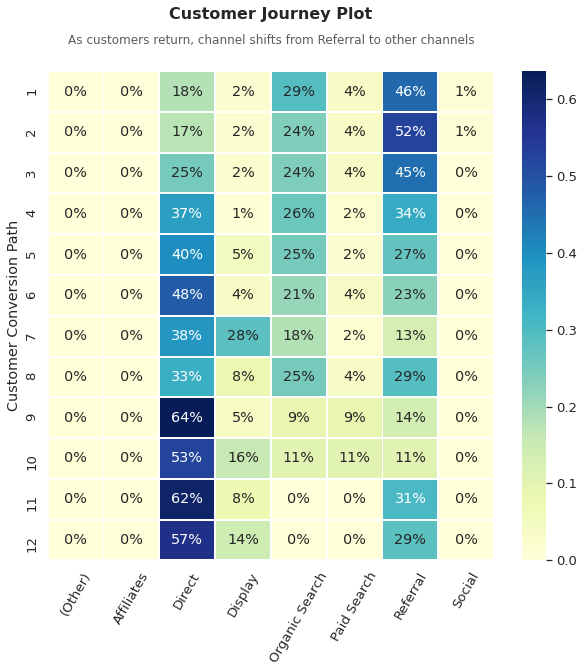

In [ ]:
fig, ax = plt.subplots(figsize=(10,9))  
sns.heatmap(pivotted, cmap = "YlGnBu" ,linewidths=1, annot = True,fmt='.0%')
sns.set(font_scale=1.2)
ax.set_xlabel('')
ax.set_ylabel('Customer Conversion Path')
ax.text(x=0.5, y=1.1, s='Customer Journey Plot', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='As customers return, channel shifts from Referral to other channels', fontsize=12, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
plt.xticks(rotation=60) 
